# Compute Magnitudes from Pickle SED in Auxtel filters (SDSS prime)

- author Sylvie Dagoret-Campagne
- creation date : 2024/07/29
- update : 2024/07/30 : add spectroscopy type to colorbar and axis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Your current machine name is iMac-de-Sylvie.local. Check your python environment


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/AtmosphericTransmission/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

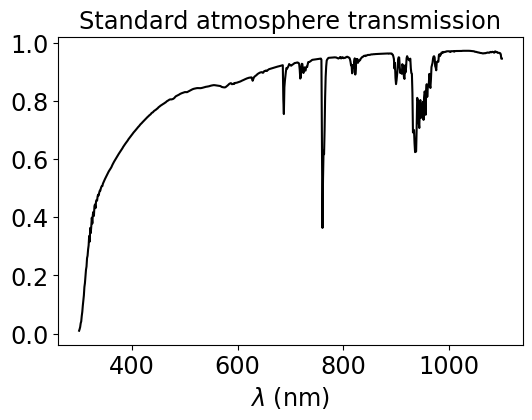

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

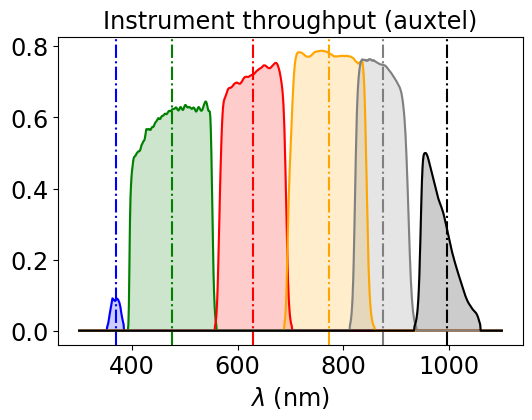

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

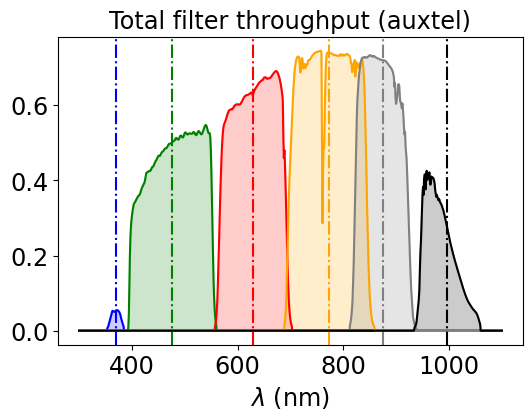

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

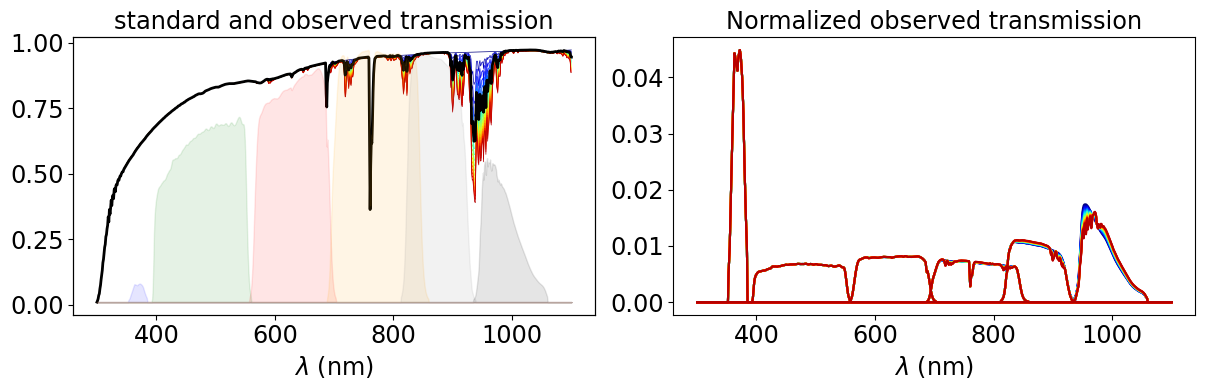

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## SED

In [20]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [21]:
seddir = os.path.join(fdir, 'pysynphot', 'pickles')

In [22]:
seddir_uvi = os.path.join(seddir,"dat_uvi")
seddir_uvk = os.path.join(seddir,"dat_uvk")

In [23]:
all_pickles_uvi = sorted(os.listdir(seddir_uvi))
all_pickles_uvk = sorted(os.listdir(seddir_uvk))

In [24]:
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")

In [25]:
hdul = fits.open(file_ref)

In [26]:
df_pickle = pd.DataFrame(hdul[1].data)

In [27]:
df_pickle

,FILENAME,SPTYPE
0,pickles_uk_1,O5V
1,pickles_uk_2,O9V
2,pickles_uk_3,B0V
3,pickles_uk_4,B1V
4,pickles_uk_5,B3V
...,...,...
126,pickles_uk_127,G8I
127,pickles_uk_128,K2I
128,pickles_uk_129,K3I
129,pickles_uk_130,K4I


In [28]:
NSED = len(df_pickle)

In [29]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

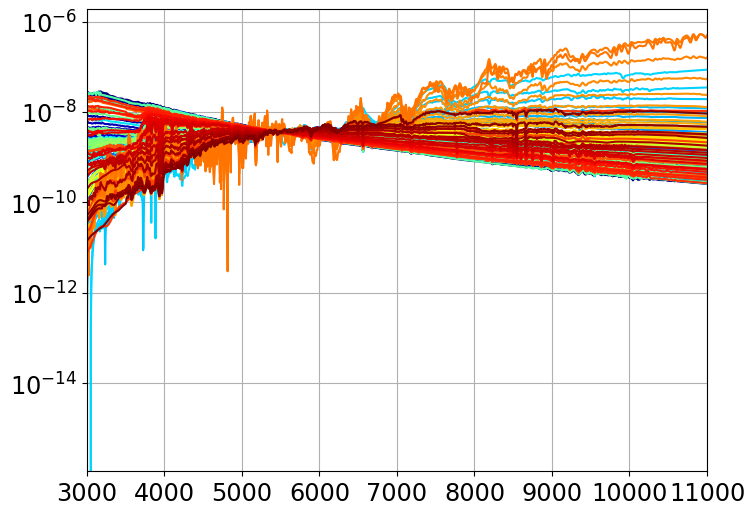

In [30]:
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    if index <= 103 or index >= 105:
        plt.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
plt.yscale('log')
plt.xlim(3000.,11000)
plt.grid()
    

## Convert SED in rubinsim format

In [31]:
all_sed = []
zmag = 20.0
for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    wl= dff.WAVELENGTH.values
    flux = dff.FLUX.values
    #wavelen (nm)
    #flambda (ergs/cm^2/s/nm)
    the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
    all_sed.append(the_sed) 

### Check the calculation of the Magnitude and the ADC counts (observation)

In [32]:
the_sed = all_sed[0]

In [33]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[the_sed.name]).T

,O5V
u,18.312840
g,18.755737
r,19.353637
i,19.754387
z,20.000000
y,20.202393


In [34]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_std = {}
for index,f in enumerate(filter_tagnames) :
    adcs_std[f] = the_sed.calc_adu(pc.bandpass_total_std[f],photoparams)
    
pd.DataFrame(adcs_std, index=[the_sed.name]).T

,O5V
u,3603.264075
g,113188.667260
r,53149.913149
i,39604.231177
z,18608.867736
y,5228.740676


## Generate dataframe with magnitudes

In [35]:
df_out = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                 "aduu","adug","adur","adui","aduz","aduy"])

for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    the_sed = all_sed[index] 
    for index2,f in enumerate(filter_tagnames) :
        mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        adcs_std[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
        df_out.loc[index] = [ index,filename, spectype ,
                              mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                             adcs_std["u"],adcs_std["g"],adcs_std["r"],adcs_std["i"],adcs_std["z"],adcs_std["y"]]
                                

In [36]:
df_out

,index,filename,spectype,magu,magg,magr,magi,magz,magy,aduu,adug,adur,adui,aduz,aduy
0,0,pickles_uk_1.fits,O5V,18.312840,18.755737,19.353637,19.754387,20.0,20.202393,-8.891740,-12.634507,-11.813756,-11.494354,-10.6743,-9.295993
1,1,pickles_uk_2.fits,O9V,18.384982,18.767218,19.364893,19.739323,20.0,20.214705,-8.819599,-12.623026,-11.802501,-11.509417,-10.6743,-9.283681
2,2,pickles_uk_3.fits,B0V,18.547236,18.838381,19.405874,19.770695,20.0,20.187712,-8.657345,-12.551863,-11.761520,-11.478046,-10.6743,-9.310673
3,3,pickles_uk_4.fits,B1V,18.855968,19.014001,19.485001,19.828298,20.0,20.187120,-8.348613,-12.376243,-11.682393,-11.420442,-10.6743,-9.311265
4,4,pickles_uk_5.fits,B3V,19.208993,19.107231,19.548564,19.819678,20.0,20.179101,-7.995587,-12.283014,-11.618830,-11.429062,-10.6743,-9.319284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,126,pickles_uk_127.fits,G8I,23.538076,21.209619,20.249451,20.045343,20.0,19.925889,-3.666504,-10.180626,-10.917943,-11.203398,-10.6743,-9.572496
127,127,pickles_uk_128.fits,K2I,24.651594,21.669869,20.474335,20.126273,20.0,19.829520,-2.552986,-9.720375,-10.693058,-11.122467,-10.6743,-9.668866
128,128,pickles_uk_129.fits,K3I,24.918072,21.844178,20.540260,20.127374,20.0,19.815444,-2.286509,-9.546067,-10.627134,-11.121367,-10.6743,-9.682941
129,129,pickles_uk_130.fits,K4I,25.406624,22.259812,20.872796,20.289719,20.0,19.832819,-1.797957,-9.130432,-10.294598,-10.959022,-10.6743,-9.665566


In [37]:
df_out = df_out[df_out.index != 104]

In [38]:
df_out["magG_R"] = df_out["magg"] - df_out["magr"]
df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
df_out["aduG_R"] = df_out["adug"] - df_out["adur"]
df_out["aduZ_Y"] = df_out["aduz"] - df_out["aduy"]

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/3374908979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["magG_R"] = df_out["magg"] - df_out["magr"]
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/3374908979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/3374908979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [39]:
df_out.spectype.values

array(['O5V', 'O9V', 'B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'A0V',
       'A2V', 'A3V', 'A5V', 'A7V', 'F0V', 'F2V', 'F5V', 'wF5V', 'F6V',
       'rF6V', 'F8V', 'wF8V', 'rF8V', 'G0V', 'wG0V', 'rG0V', 'G2V', 'G5V',
       'wG5V', 'rG5V', 'G8V', 'K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V',
       'K7V', 'M0V', 'M1V', 'M2V', 'M2.5V', 'M3V', 'M4V', 'M5V', 'M6V',
       'B2IV', 'B6IV', 'A0IV', 'A47IV', 'F02IV', 'F5IV', 'F8IV', 'G0IV',
       'G2IV', 'G5IV', 'G8IV', 'K0IV', 'K1IV', 'K3IV', 'O8III', 'B12III',
       'B3III', 'B5III', 'B9III', 'A0III', 'A3III', 'A5III', 'A7III',
       'F0III', 'F2III', 'F5III', 'G0III', 'G5III', 'wG5III', 'rG5III',
       'G8III', 'wG8III', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III',
       'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III',
       'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'M0III', 'M1III',
       'M2III', 'M3III', 'M4III', 'M5III', 'M6III', 'M7III', 'M8III',
       'M9III', 'B2II', 'B5II', 'F0II', 'F2II', 'G5II', '

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/1467569145.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels,rotation=0);


Text(0, 0.5, 'G-R (adu) (mag)')

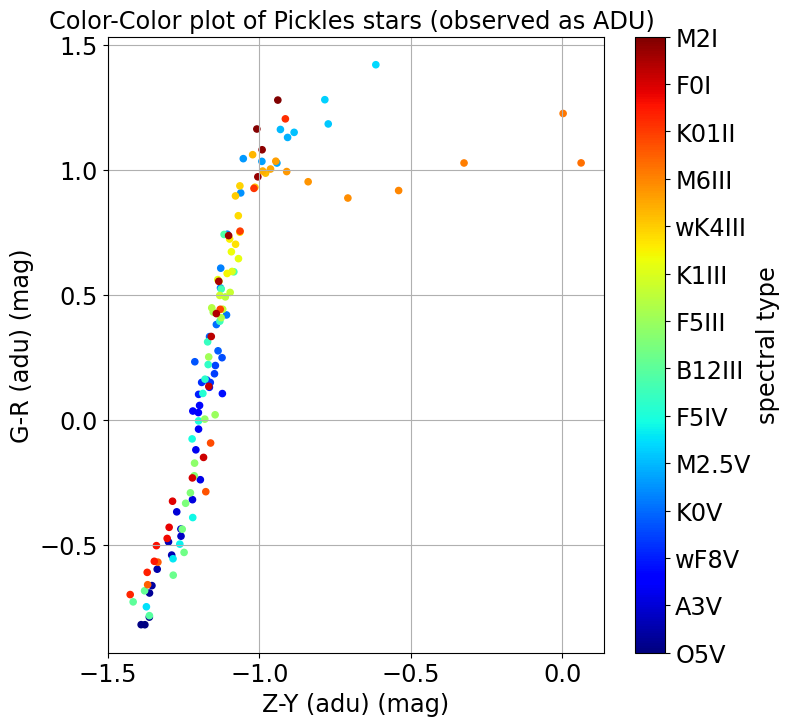

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="o",c="index",colormap="jet",ax=ax,grid=True,colorbar=False)
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot of Pickles stars (observed as ADU) ")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/854831084.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels,rotation=0);


Text(0, 0.5, 'G-R  (mag)')

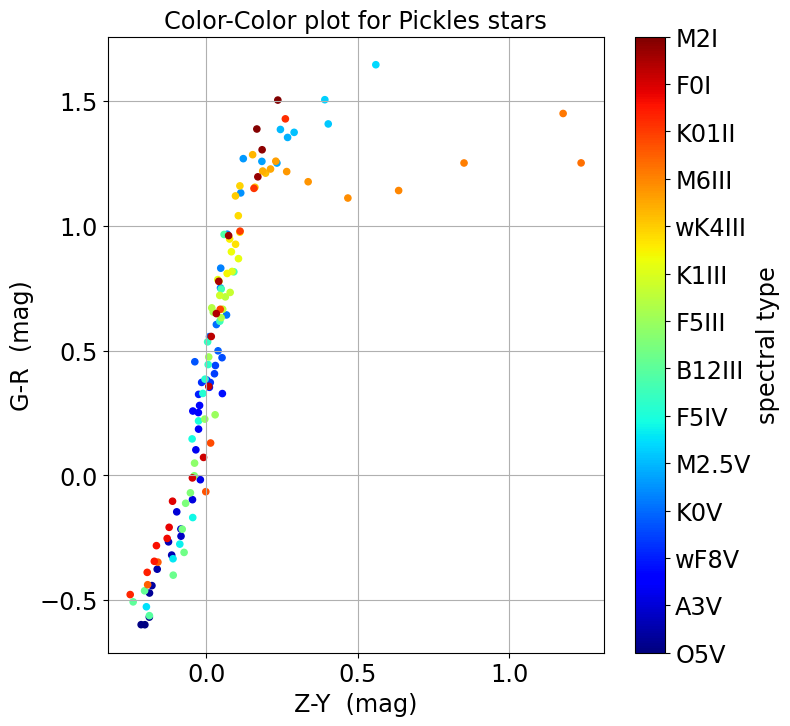

In [41]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="o",c="index",colormap="jet",ax=ax,grid=True,colorbar=False)

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")

/Users/dagoret/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/1202577620.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels1,rotation=90)
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_6387/1202577620.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels2,rotation=90)


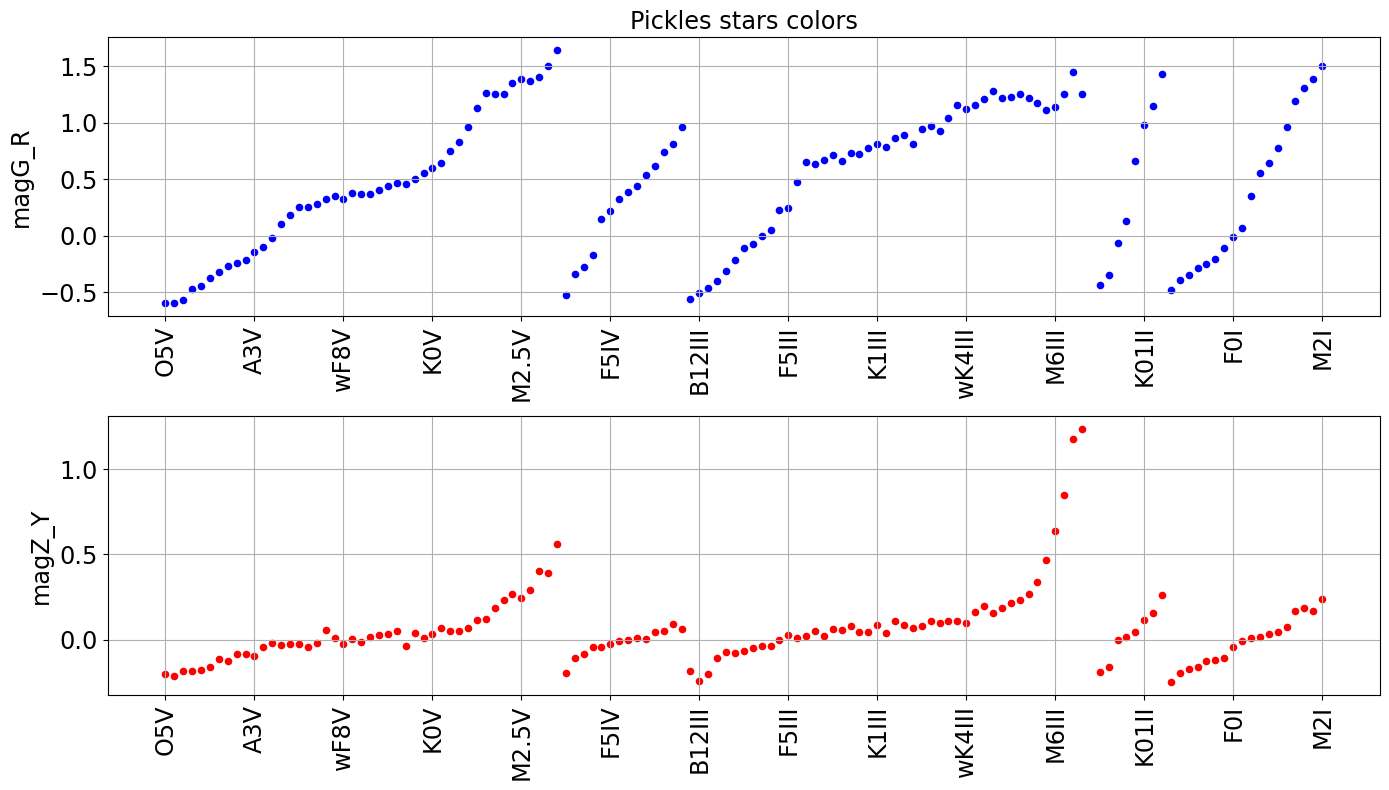

In [42]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
df_out.plot.scatter(x="index",y="magG_R",ax=ax1,grid=True,c="b")
df_out.plot.scatter(x="index",y="magZ_Y",ax=ax2,grid=True,c="r")

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

ax1.locator_params(axis='x', nbins=2*len(labels1)) 
ax2.locator_params(axis='x', nbins=2*len(labels2)) 

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

Nlabels1 = len(labels1)
for ilab in range(1,Nlabels1-1):
    the_label = int(labels1[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels1[ilab] = df_out.loc[the_label,"spectype"]
ax1.set_xticklabels(labels1,rotation=90)
ax1.set_xlabel(None)


Nlabels2 = len(labels2)
for ilab in range(1,Nlabels2-1):
    the_label = int(labels2[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels2[ilab] = df_out.loc[the_label,"spectype"]
ax2.set_xticklabels(labels2,rotation=90)
ax2.set_xlabel(None)

ax1.set_title("Pickles stars colors")

plt.tight_layout()